# Label Distribution Plot
We define a step of a random walk as $A * P(N)$ where $A$ is the adjacency matrix of a (PPI) network and $P(N)$ is the distribution of labels. $P(i) > 0$ means that the node is labeled in the graph.

We then look at the number of steps needed for $P(N)$ to become greater than $0$ for all nodes. This could be an estimate as to how many layers of GCN we'd need.

In [37]:
import pandas as pd
import networkx as nx
import numpy as np
import h5py

import gcnIO, os

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Times New Roman')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%matplotlib inline

In [5]:
model_dir = '../data/GCN/training/2018_12_04_16_38_36/'

args, data_file = gcnIO.load_hyper_params(model_dir)
data = gcnIO.load_hdf_data(data_file)
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feature_names = data

Hyper-Parameters read from ../data/GCN/training/2018_12_04_16_38_36/hyper_params.txt


In [66]:
if not val_mask is None:
    p_0_all = np.logical_or(np.logical_or(train_mask, test_mask), val_mask)
    p_0_pos = np.logical_or(np.logical_or(y_train, y_test), y_val)
else:
    p_0_all = np.logical_or(train_mask, test_mask)
    p_0_pos = np.logical_or(y_train, y_test)

p_0_neg = np.logical_xor(p_0_pos.reshape(-1), p_0_all)

p_0_all = p_0_all / p_0_all.sum()
p_0_pos = p_0_pos / p_0_pos.sum()
p_0_neg = p_0_neg / p_0_neg.sum()

In [67]:
rw_all = [p_0_all]
rw_pos = [p_0_pos]
rw_neg = [p_0_neg]
for i in range(5):
    p_i_all = adj.dot(rw_all[-1])
    rw_all.append(p_i_all)
    
    p_i_pos = adj.dot(rw_pos[-1])
    rw_pos.append(p_i_pos)
    
    p_i_neg = adj.dot(rw_neg[-1])
    rw_neg.append(p_i_neg)

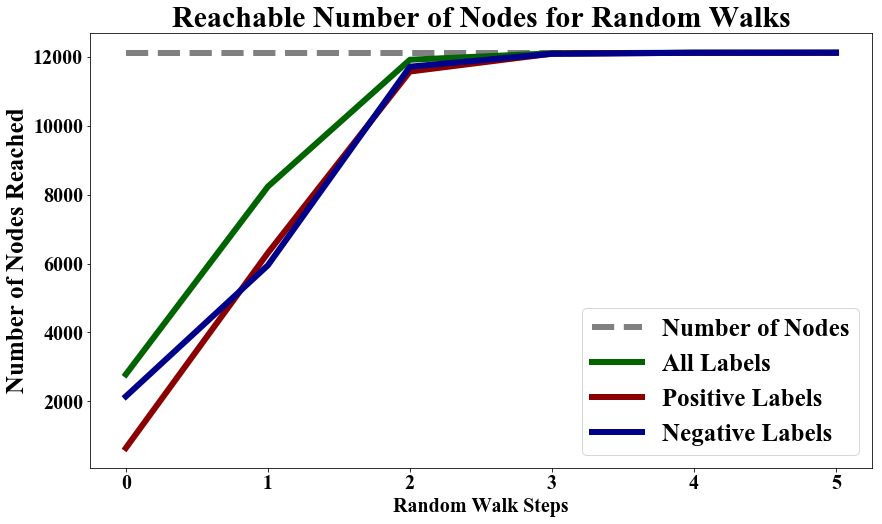

In [69]:
fig = plt.figure(figsize=(14, 8))
plt.plot([0, len(rw_all)-1], [adj.shape[0], adj.shape[0]], color='gray', lw=6, linestyle='--', label='Number of Nodes')
plt.plot([np.count_nonzero(i) for i in rw_all], c='darkgreen', lw=6, label='All Labels')
plt.plot([np.count_nonzero(i) for i in rw_pos], c='darkred', lw=6, label='Positive Labels')
plt.plot([np.count_nonzero(i) for i in rw_neg], c='darkblue', lw=6, label='Negative Labels')
plt.xlabel('Random Walk Steps', fontsize=20)
plt.ylabel('Number of Nodes Reached', fontsize=25)
plt.tick_params(axis='both', labelsize=20)

plt.legend(loc='lower right', fontsize=25)
plt.title('Reachable Number of Nodes for Random Walks', fontsize=30)
fig.savefig(os.path.join(model_dir, 'random_walk_reachability.svg'))

640